# criticality figure for paper

In [86]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import munch
import utils
import glob
import utm
import os

fig_dir = "../figures"
matplotlib.rc("font", size=7)

In [91]:
# Towyos separate
data_files = glob.glob("../proc_data/TY*.mat")
TYs = np.asarray([munch.munchify(utils.loadmat(file)) for file in data_files])
P5TYs = [TY for TY in TYs if ((TY.sill == "P5") and (TY.year == 2014))]
# Bathymetry
bathy = xr.open_dataset("../raw_data/merged_200_-171.5_-167.5_-11_-6.5.nc")
bathyP5 = bathy.isel(lon=(bathy.lon < -168.5) & (bathy.lon > -168.8), lat=(bathy.lat > -8.3) & (bathy.lat < -7.9))

data_file = "../raw_data/samoan_passage_bathymetry_200m_merged.mat"
B = munch.munchify(utils.loadmat(data_file)["bathy2"])
long, latg = np.meshgrid(B.lon, B.lat)
B.xg, B.yg, _, _ = utm.from_latlon(latg, long)

# Towyos together
ds = xr.open_dataset("../proc_data/stacked_towyos.nc")
OI = xr.open_dataset("../raw_data/non_divergent_OI_fields.nc")

# TG long wave analysis
dm = utils.loadmat("../proc_data/TG_phase_speed.mat")
angles = dm["angles"]
cp_us = dm["cp_us"]
cp_ds = dm["cp_ds"]

Single layer Froude number analysis

In [92]:
# define the density differene using a fixed distance from the isopycnal height
sig4i = 1045.93
sig4bar = 1045.9
dz = 50  # distance from 'interface top'
g = 9.81

# tile z grid for convenience
zg = np.tile(ds.z.values[:, np.newaxis], (1, ds.pfl.size))

# interface height
zi = utils.nan_interp(sig4i, ds.sig4_sorted.values, zg, axis=0)

# density distance dz below the interface
sig4dz = np.full_like(zi, np.nan)
for pfl in ds.pfl:
    sig4dz[pfl] = ds.sig4_sorted.isel(pfl=pfl).interp(z=zi[pfl]-dz)

dsig4 = sig4dz - sig4i
# reduced gravity
gp = g*dsig4/sig4bar

# overflow average velocity
inlayer = ds.sig4_sorted > sig4i
# depths within layer
zo = ds.z.where(inlayer)
# thickness
H = inlayer.sum("z")
# Can use sum to integrate because measurements every 1 m in towyos.
uo = ds.u.where(inlayer).sum("z")/H
vo = ds.v.where(inlayer).sum("z")/H
# Velocity for single layer estimate
U = np.sqrt(uo**2 + vo**2)
# Froude number
Fr = U/np.sqrt(gp*H)

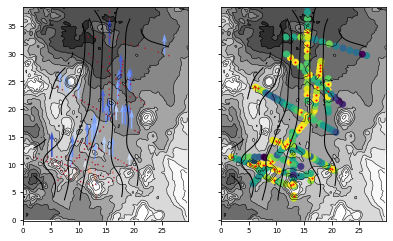

In [94]:
l = 4000
SNR = 2
dc = 100  # Threshold thickness
step = 3
inside_hull = (OI.PSIerr.sel(l=l, SNR=SNR) < 0.2) #& (ds.d > dc)
vmin = 4500.0
vmax = 5500.0
dv = 100
scale = 2000
bcmap = "Greys"
ccolors = "k"

PSIm = OI.PSI.sel(l=l, SNR=SNR).where(inside_hull)
Um = OI.U.sel(l=l, SNR=SNR).where(inside_hull)
Vm = OI.V.sel(l=l, SNR=SNR).where(inside_hull)

fig, axs = plt.subplots(1, 2, figsize=(6.5, 4), sharex=True, sharey=True)
axs[0].set_aspect("equal")
axs[1].set_aspect("equal")

# Bathymetry for sill P5
wlon, elon, slat, nlat = -168.77, -168.5, -8.3, -7.95
i1, i2 = np.searchsorted(B["lon"], [wlon, elon])
j1, j2 = np.searchsorted(B["lat"], [slat, nlat])

x0 = B.xg[j1, i1]
y0 = B.yg[j1, i1]

for ax in axs:
    CB = ax.contourf(
        1e-3*(B.xg[j1:j2, i1:i2] - x0),
        1e-3*(B.yg[j1:j2, i1:i2] - y0),
        B.merged[j1:j2, i1:i2],
        np.arange(vmin, vmax + dv, dv),
        cmap=bcmap,
        extend="both",
    )
    ax.contour(
        1e-3*(B.xg[j1:j2, i1:i2] - x0),
        1e-3*(B.yg[j1:j2, i1:i2] - y0),
        B.merged[j1:j2, i1:i2],
        np.arange(vmin, vmax + dv, dv),
        colors=ccolors,
        linewidths=0.5,
        linestyles="solid",
    )

    ax.contour(1e-3*(OI.x - x0), 1e-3*(OI.y - y0), PSIm, np.arange(OI.PSI.min(), OI.PSI.max(), 3e5), colors="black", linewidths=1)


# ax.contour(bathyP5.lon, bathyP5.lat, bathyP5.z, colors="k")

CS = axs[1].scatter(1e-3*(ds.x[::step] - x0), 1e-3*(ds.y[::step] - y0), c=Fr[::step], vmax=1.)
axs[1].plot(1e-3*(ds.x[::step] - x0)[Fr[::step] > 1], 1e-3*(ds.y[::step] - y0)[Fr[::step] > 1], 'r.', ms=2)
# # CS = axs[1].scatter(ds.lon, ds.lat, c=Fr)
# cb = plt.colorbar(CS)
# cb.set_label("Froude number")

mn = 0
cpux = -cp_us*np.sin(angles)[:, np.newaxis]
cpuy = -cp_us*np.cos(angles)[:, np.newaxis]
cpdx = -cp_ds*np.sin(angles)[:, np.newaxis]
cpdy = -cp_ds*np.cos(angles)[:, np.newaxis]

# supercrit = cp_us[::step, mn] > 0
s0 = 3
axs[0].quiver(1e-3*(ds.x[s0::step] - x0), 1e-3*(ds.y[s0::step] - y0), cpux[s0::step, mn], cpuy[s0::step, mn], cp_us[s0::step, mn], scale=1, cmap="coolwarm", width=0.01)
# axs[0].quiver(1e-3*(ds.x[::step] - x0), 1e-3*(ds.y[::step] - y0), cpdx[::step, mn], cpdy[::step, mn], color='g', scale=1)

name = "criticality"
fig.savefig(os.path.join(fig_dir, name + ".png"), dpi=300, bbox_inches="tight", pad_inches=0)
fig.savefig(os.path.join(fig_dir, name + ".pdf"), dpi=300, bbox_inches="tight", pad_inches=0)